# Filters
In this notebook, the following steps are accomplished:
1.  Raw streamflow data is pulled
2.  Holes in the data are filled using data from the previous year
3.  A variety of filtering techniques are applied to the data to reduce noise

## Notes
Questions:
* Train on all 3 rivers, or individual rivers? River transfer knowledge?
* Which giver better result for 5 day forcast: seq to seq or rolling predictions?

In [10]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from dateutil.relativedelta import relativedelta
from pandas import DataFrame
#from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'
look = 21
lead = 1 # 3, 5, 7, 10
plt.rcParams['figure.figsize'] = [20, 10]


## Raw Data
In this step, the raw data is pulled, and each river's flow becomes the column of the dataframe 'flows'
indexed temporally.

In [19]:
#1934-4-01  2018-07-09
df = pd.read_csv('../../data/streamflw_precipitation/Ganges.csv', usecols=[3,4], index_col=0,header=0,parse_dates=True) #Brahmaputra #Meghna
df1 = pd.read_csv('../../data/streamflw_precipitation/Brahmaputra.csv', usecols=[3,4], index_col=0,header=0,parse_dates=True) #Brahmaputra #Meghna
df2 = pd.read_csv('../../data/streamflw_precipitation/Meghna.csv', usecols=[3,4], index_col=0,header=0,parse_dates=True) #Brahmaputra #Meghna

Ganges      = df["Q (m3/s)"].loc['1980-01-01':]
Brahmaputra = df1["Q (m3/s)"].loc['1980-01-01':]
Meghna      = df2["Q (m3/s)"].loc['1980-01-01':]


flows = pd.concat([Ganges, Brahmaputra, Meghna], axis=1, sort=False)
flows.columns = ['Ganges', 'Brahmaputra', 'Meghna']


print(flows.head(3))
print(flows.tail(3))

            Ganges  Brahmaputra  Meghna
Date                                   
1980-01-01  1600.0       7500.0    92.3
1980-01-02  1620.0       7300.0    91.4
1980-01-03  1620.0       7100.0    90.6
            Ganges  Brahmaputra  Meghna
Date                                   
2018-07-07  5337.0      61665.0  2470.0
2018-07-08  6366.0      62437.0  2965.0
2018-07-09  7206.0      61921.0  2999.0


In [4]:
# Makes plots a reasonable size
plt.rcParams['figure.figsize'] = [20, 10]

<Figure size 14400x1080 with 0 Axes>

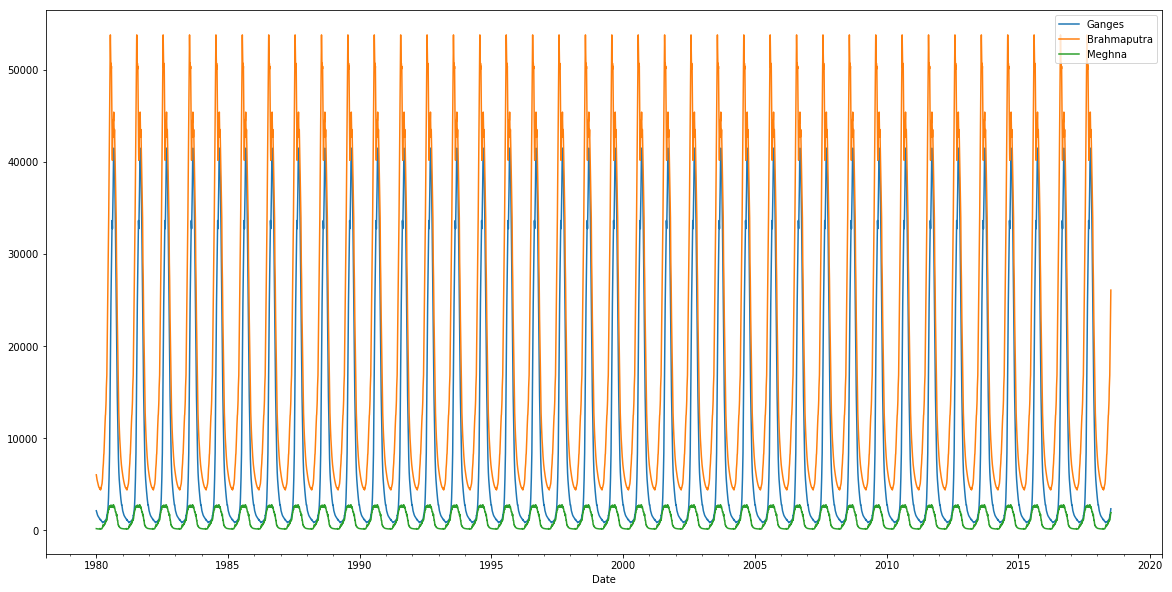

In [5]:
# Returns a time series of equal length to arguement ts, but each year consists of an avg year
def extract_avg_seasonality(ts):
    avgSeason = average_season(ts)
    
    n = len(ts)/len(avgSeason) + 1
        
    avgSeasons = pd.concat([avgSeason] * n, ignore_index=True)
    
    avgSeasons = avgSeasons.iloc[:len(ts)]
    
    avgSeasons = avgSeasons.set_index(ts.index)
    
    avgSeasons.columns = ts.columns
    
    return avgSeasons

# Helper function that returns the average year flow
def average_season(ts):
    avg_season =  np.array(ts.groupby([ts.index.month,ts.index.day]).mean())
    avg_season = pd.DataFrame(avg_season)
    avg_season.columns = ts.columns
    return avg_season

seasonality = extract_avg_seasonality(flows)
figure(figsize=(200,15))
seasonality.plot()
plt.show()

#print(seasonality)


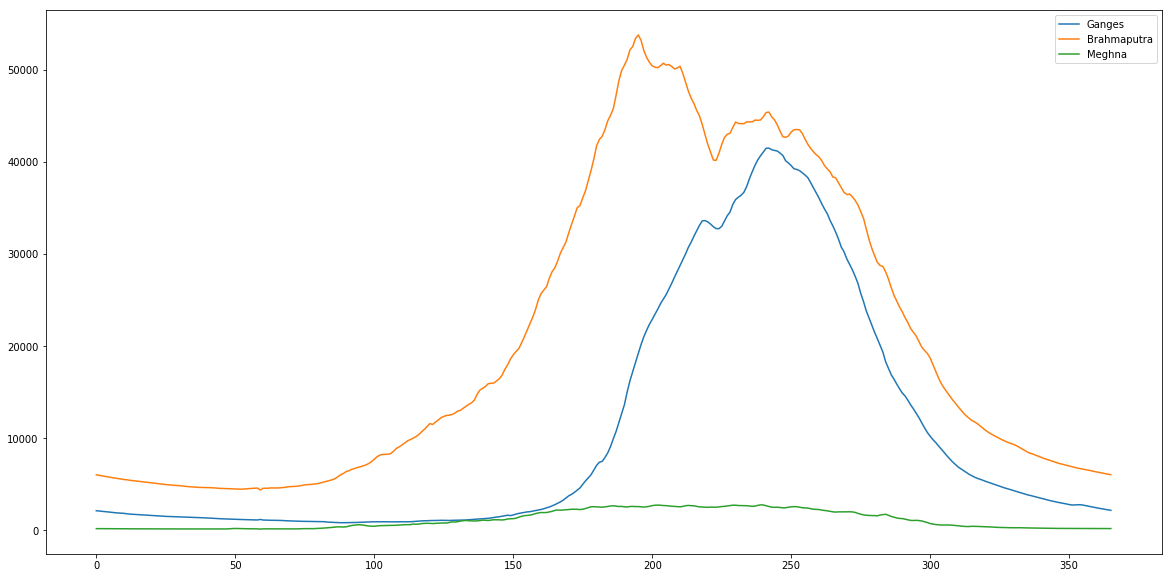

In [6]:
# The average year visualized
average_season(flows).plot()
plt.show()

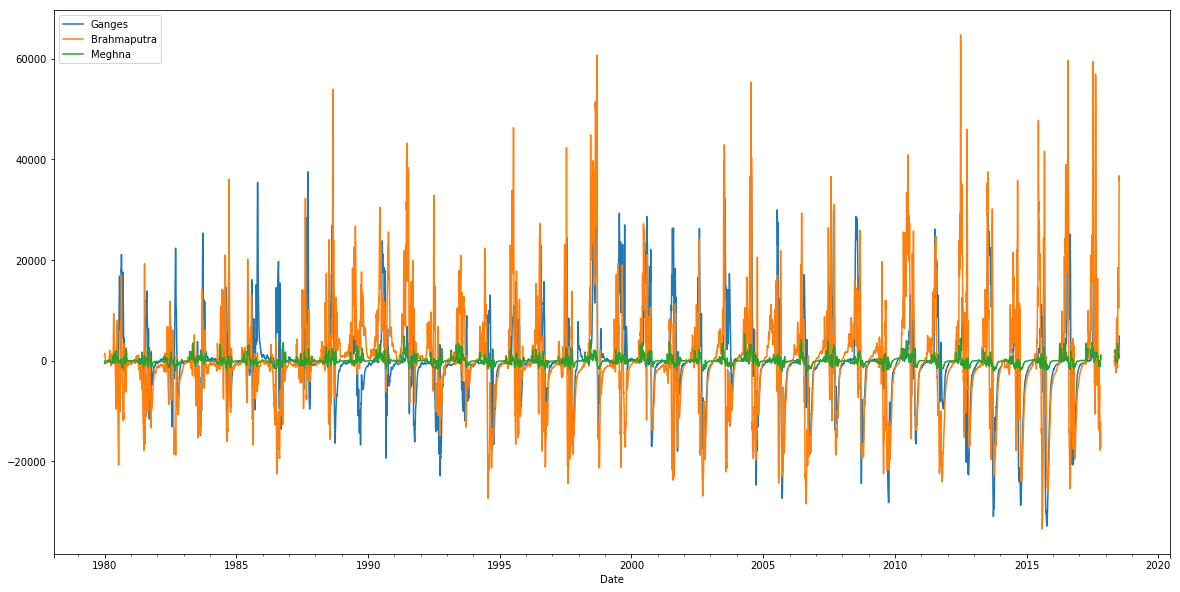

In [7]:
flows_unseasoned = flows - seasonality

# Data with average subtracted
flows_unseasoned.plot()
plt.show()

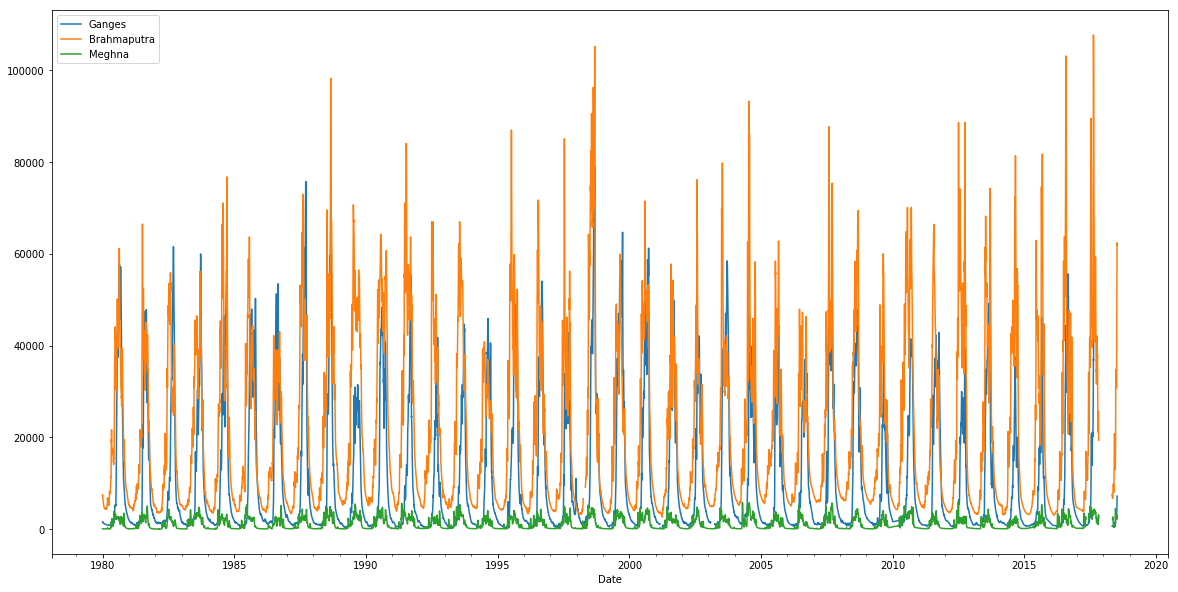

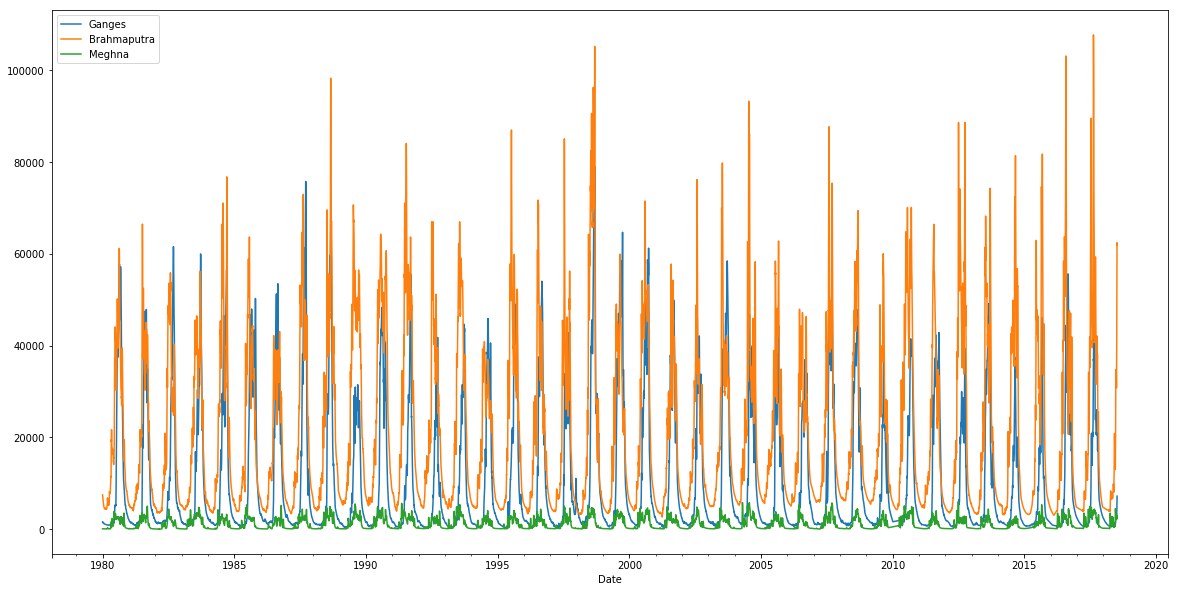

In [8]:
'''
print(flows[flows.iloc[:,0].isnull()])
flows[flows.iloc[:,0].isnull()] = flows.iloc[:,0].groupby([df['Date'].dt.month,df['Date'].dt.day].shift())
print(flows[flows.iloc[:,0].isnull()])
'''

# fills NaNs with previous year
def replace_NaN(column):

    NaNs = column[column.isnull()]
    #NaNs_initial = NaNs = column[]
    for i in range (len(NaNs)):
        current = NaNs.index[i]
        prv = current - relativedelta(years=1) #,'''days = 1''')
        #add condition to see if there is a previous datapoint and if it's not null, else go into the future
        #a mask could work here to select all of the same month and year and find the closest value
        #then impliment alg bellow
        column[current] = column[prv]
        #column[current] = seasonality[current] #replacing with average value may be preferable
    return column

        
    
#df['Ganges'].groupby([flows.index.month,flows.index.day])
flows.plot()
plt.show()


flows[flows.columns] = flows[flows.columns].apply(replace_NaN)

flows.plot()
plt.show()

In [9]:
'''
Idea:
    if first nan encountered, find most similar datapoint j to previous day, 
    of a different year while being same month and day of said month.Take difference between j and j+1 
    and add that to the value of datapoint j. Repeat with next values in NaN hole (or just use the same 
    j and do it until reached j + size of NaN hole). Then do the same but backwards in a new array. Multiply
    each array with scalar so the detached endpoints match values surrounding NaN hole. Then take the mean of arrays.
    
    Or you could do this with every non NaN array the size of NaN hol
    
    pseudocode
    
    mask: for i in df
        j = 0
        size = NaN hole size
        while df[i + j] is nan:
            j -= 1
        find most similar same month & day value to df[i+j]
        
        
        
        caveat****** plug values are differenced from the value before the plug (+ or -). That way a scalar multiple
        acts as an affine transformation
        
        
        mask: fill wherever condition is met
'''

'\nIdea:\n    if first nan encountered, find most similar datapoint j to previous day, \n    of a different year while being same month and day of said month.Take difference between j and j+1 \n    and add that to the value of datapoint j. Repeat with next values in NaN hole (or just use the same \n    j and do it until reached j + size of NaN hole). Then do the same but backwards in a new array. Multiply\n    each array with scalar so the detached endpoints match values surrounding NaN hole. Then take the mean of arrays.\n    \n    Or you could do this with every non NaN array the size of NaN hol\n    \n    pseudocode\n    \n    mask: for i in df\n        j = 0\n        size = NaN hole size\n        while df[i + j] is nan:\n            j -= 1\n        find most similar same month & day value to df[i+j]\n        \n        \n        \n        caveat****** plug values are differenced from the value before the plug (+ or -). That way a scalar multiple\n        acts as an affine transforma

<Figure size 14400x1080 with 0 Axes>

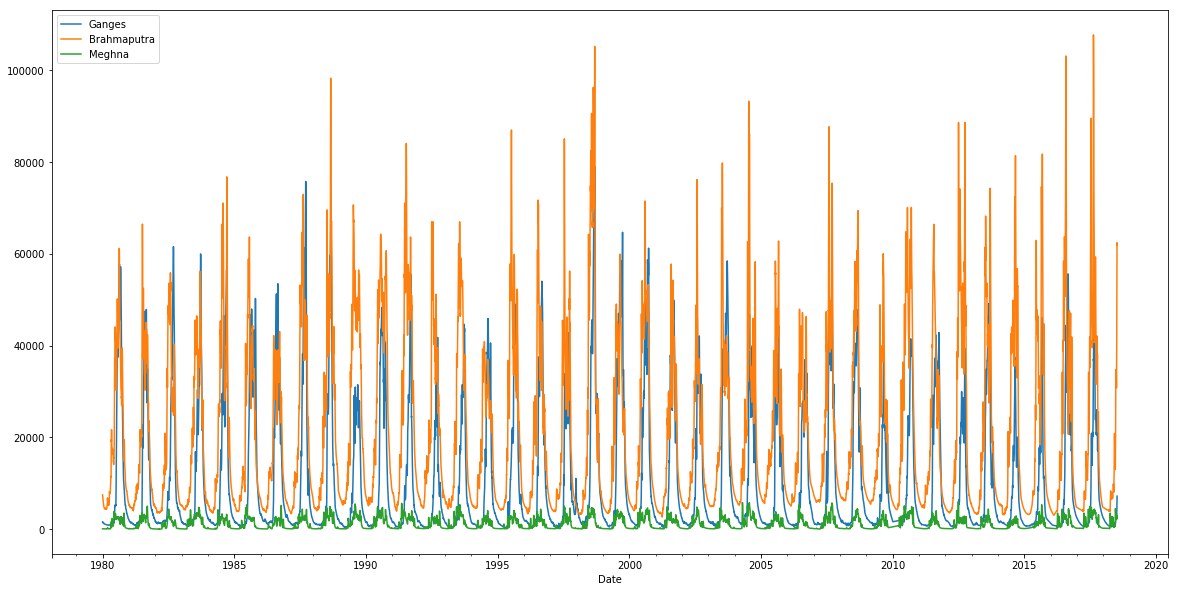

In [10]:
figure(figsize=(200,15))
flows.plot()
plt.show()

# Filters

Data

Rolling Mean Filter

In [11]:
flows_RM = flows.rolling(window=5).mean()


            Ganges  Brahmaputra   Meghna
Date                                    
1980-01-01     NaN          NaN      NaN
1980-01-02     NaN          NaN      NaN
1980-01-03     NaN          NaN      NaN
1980-01-04     NaN          NaN      NaN
1980-01-05  1594.0       7130.0    90.28
1980-01-06  1568.0       6950.0    89.14
1980-01-07  1536.0       6780.0    87.96
1980-01-08  1504.0       6622.0    86.60
1980-01-09  1474.0       6470.0    85.08
1980-01-10  1444.0       6324.0    83.44
1980-01-11  1436.0       6192.0    81.92
1980-01-12  1430.0       6056.0    80.44
1980-01-13  1416.0       5898.0    79.08
1980-01-14  1400.0       5728.0    78.00
1980-01-15  1390.0       5574.0    77.04
1980-01-16  1366.0       5434.0    75.96
1980-01-17  1340.0       5298.0    74.72
1980-01-18  1324.0       5196.0    73.36
1980-01-19  1314.0       5116.0    71.96
1980-01-20  1304.0       5038.0    70.60
1980-01-21  1292.0       4958.0    69.36
1980-01-22  1270.0       4896.0    68.28
1980-01-23  1244

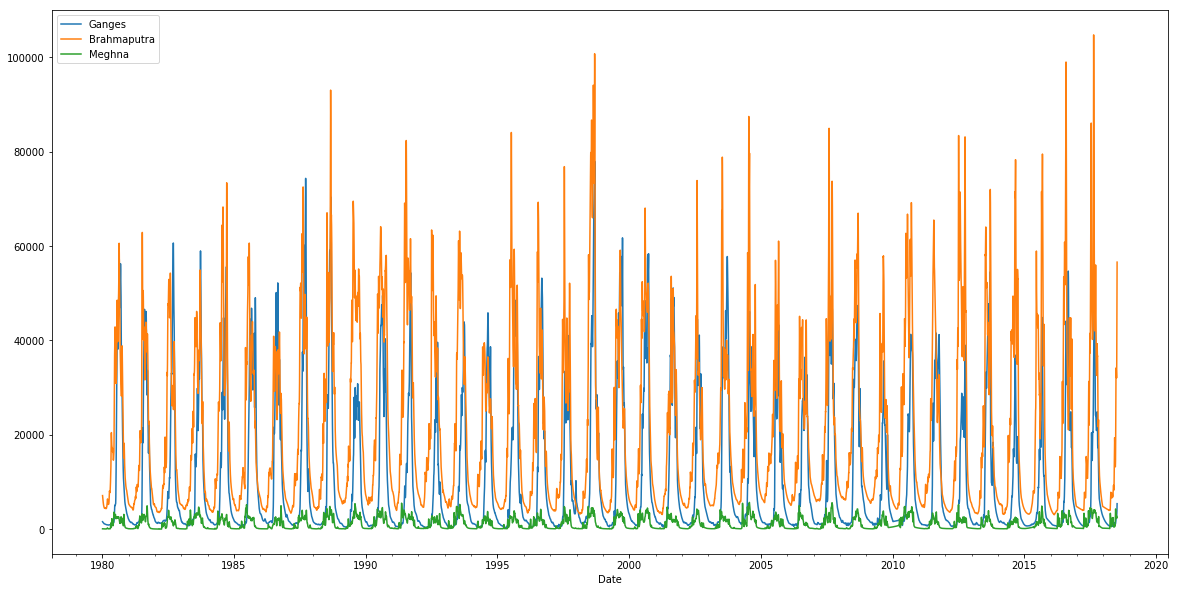

In [12]:
print(flows_RM)
print(len(flows_RM))
flows_RM.plot()
plt.show()

In [13]:
# Local Regression
from statsmodels.nonparametric import smoothers_lowess



[  92.3   91.4   90.6 ... 2470.  2965.  2999. ]
..................
..................
[7113.79483847 7113.88014683 7113.95597648 ... 6900.88650368 6846.20105283
 6848.94965283]
[  92.3   91.4   90.6 ... 2470.  2965.  2999. ]


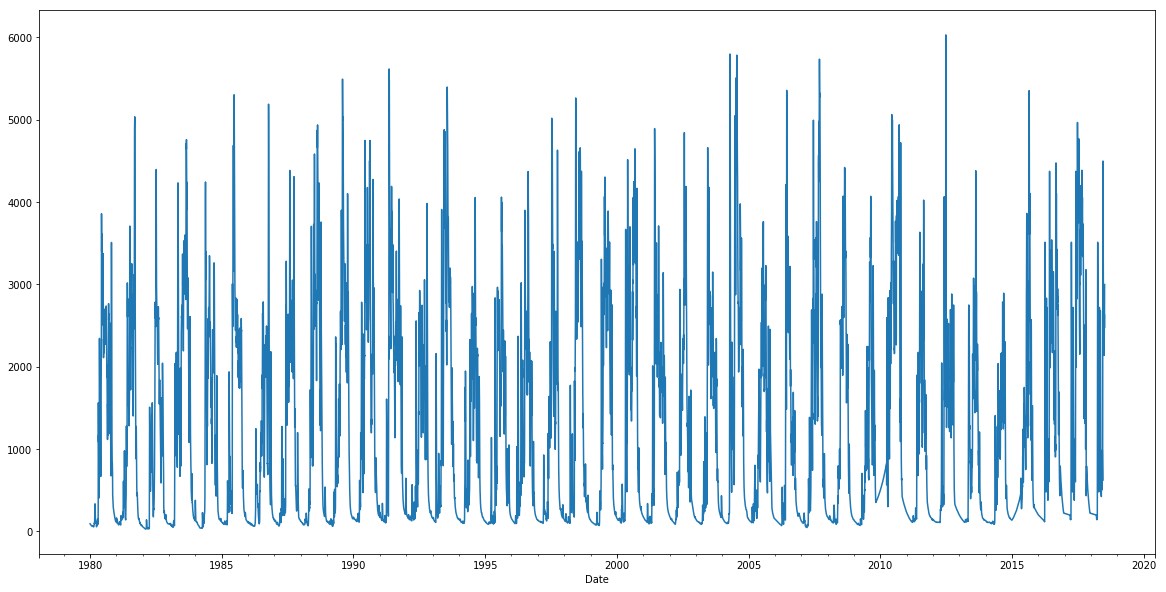

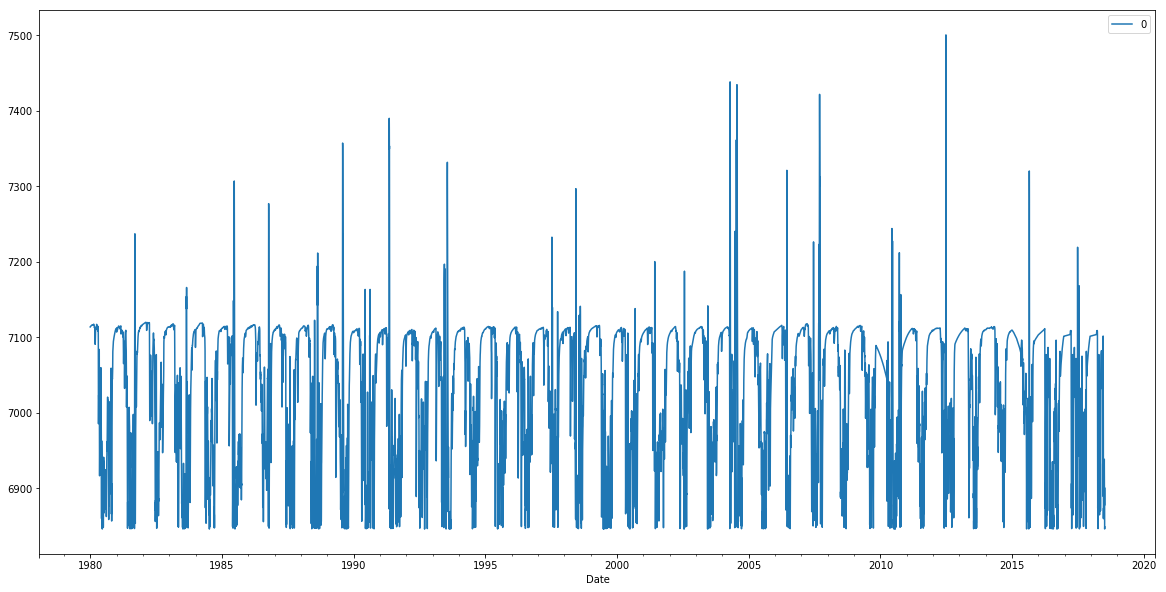

In [14]:
print(flows['Meghna'].values)
print('..................')
print('..................')
#print(range(len(flows.index)))

endog = range(len(flows.index))
exog = flows['Meghna'].values

flows_SL = smoothers_lowess.lowess(endog,
                        exog,
                        frac=1,
                        it=3, 
                        delta=0.01 * len(exog),
                        is_sorted=False,
                        missing='drop',
                        return_sorted=False)

flows_SL = pd.DataFrame(flows_SL, index = flows.index)

print(flows_SL.iloc[:,0].values)

print(flows['Meghna'].values)
                        
flows['Meghna'].plot()
flows_SL.plot()

http://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [15]:
# Savitzky-Golay and hamming
from scipy.signal import savgol_filter, hamming

https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html

In [16]:
def savgol(df):
    df = df
    filtered = savgol_filter(df, window_length = 5,
                             polyorder = 3)
    df2 = pd.DataFrame(filtered, index = df.index)
    
    return df2

#savgol(flows['Ganges'])

'''
flows_SG = flows
cols = flows.columns

#flows_SG[cols] = flows_SG[cols].apply(savgol)
# ValueError: If using all scalar values, you must pass an index
'''
flows_SG['Ganges'] = savgol(flows['Ganges'])
flows_SG['Brahmaputra'] = savgol(flows['Brahmaputra'])
flows_SG['Meghna'] = savgol(flows['Meghna'])


#savgol(flows_SG['Meghna'])
print("Savgol:")
print(flows_SG['Meghna'].shape)
print(flows_SG['Meghna'])

print("Normal:")
print(flows['Meghna'].shape)
print(flows['Meghna'])

print("SG - Normal")
print(flows_SG['Meghna']-flows['Meghna'])




/usr/local/lib/python2.7/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


NameError: name 'flows_SG' is not defined

flat:
hanning:
bartlett:
blackman:


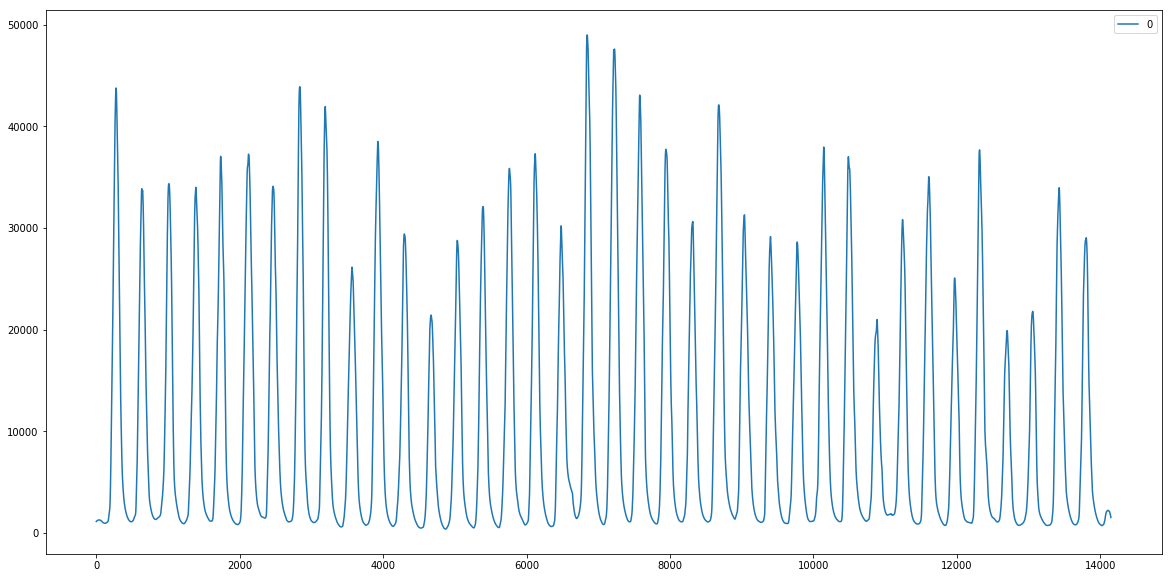

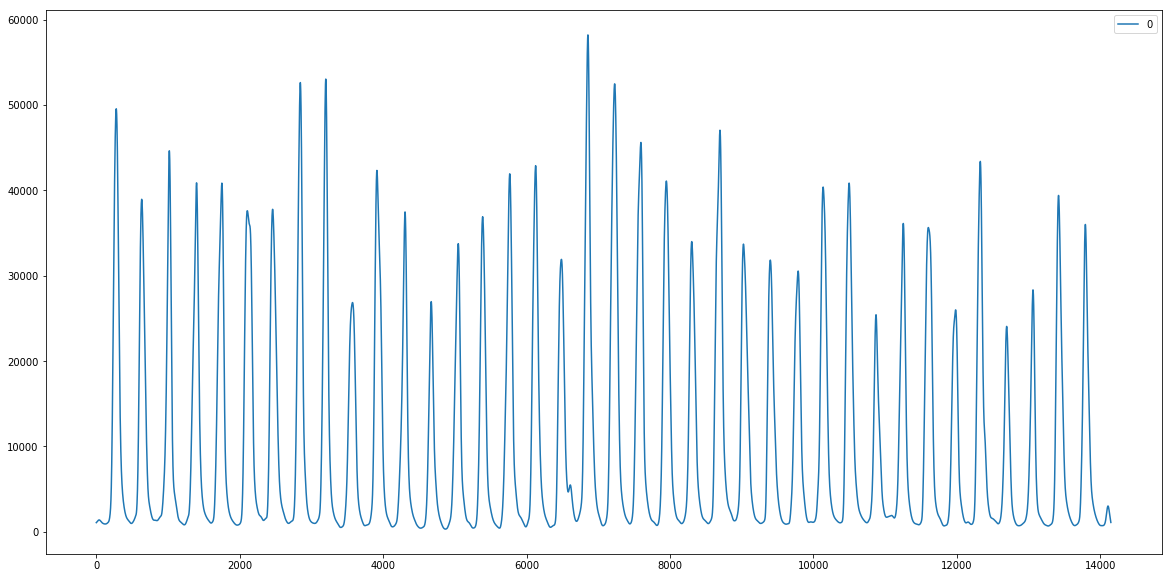

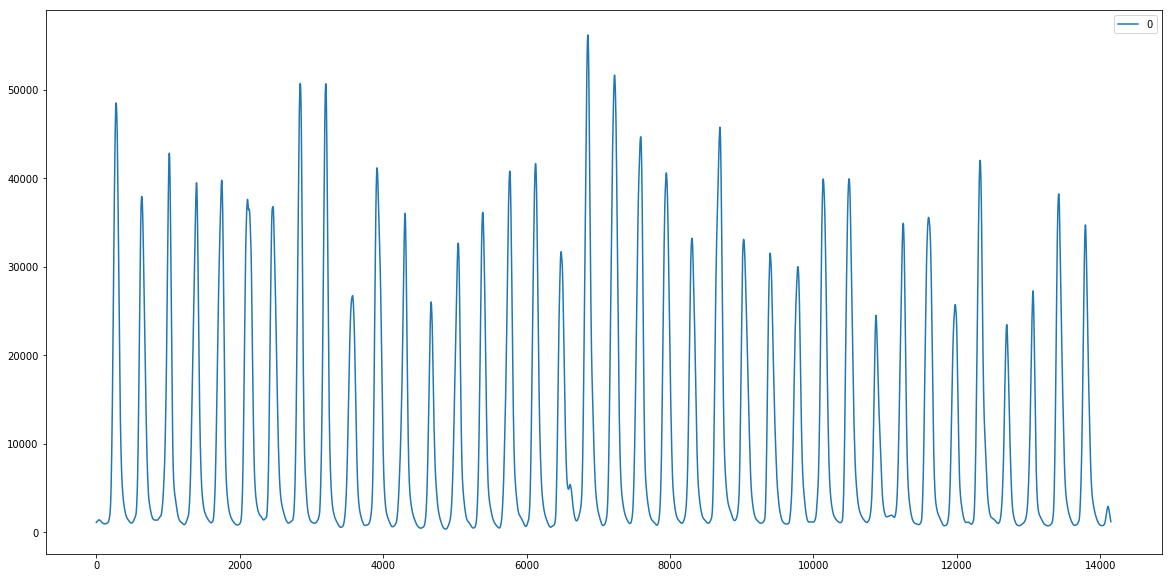

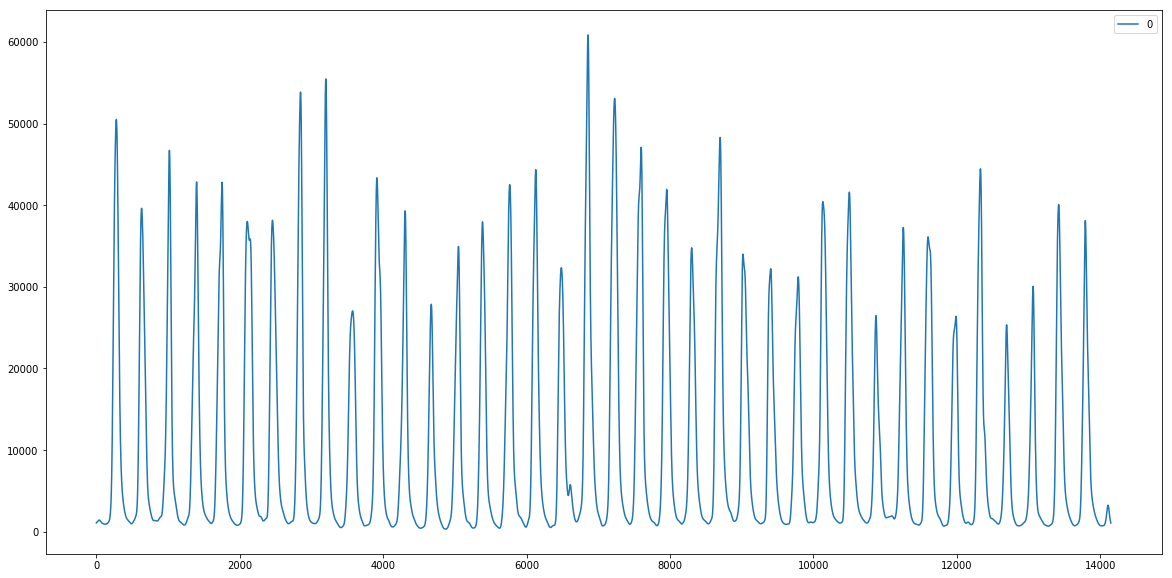

In [17]:
def smooth(x, window_len=5, window='hanning'):
    if x.ndim !=1:
        raise ValueError, "smooth only accepts 1d arrays."
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
    
    if window_len<3:
        raise ValueError, "Window length should be bigger than 3 for filtering"
        
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    
    if window =='flat':
        w = np.ones(window_len, 'd')
    
    else:
        w = eval('np.'+window+'(window_len)')
        
    y = np.convolve(w/w.sum(),s,mode='valid')
    
    y = pd.DataFrame(y)
    return y
print('flat:')
smooth(flows['Ganges'], window_len = 80, window = 'flat').plot()
print('hanning:')
smooth(flows['Ganges'], window_len = 80, window = 'hanning').plot()
print('bartlett:')
smooth(flows['Ganges'], window_len = 80, window = 'bartlett').plot()
print('blackman:')
smooth(flows['Ganges'], window_len = 80, window = 'blackman').plot()


plt.show()

In [ ]:
print(df_SG)
print(len(df_SG))
flows_SG.plot()
plt.show()


https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.hamming.html#scipy.signal.hamming

In [ ]:
def rolling_windowXY(df):
    df = df.reset_index()
    for lag in np.arange(-20,16):
        new_index = df.index + lag
        x = df.loc[new_index, df.columns[0]]
        x = pd.DataFrame(x)
        x.columns = [''.join(['Q_',str(lag)])]   
        x.index = df.index
        df = pd.concat([df,x],axis=1)
    df = df[ (pd.DatetimeIndex(df['Date']).month > 4) & (pd.DatetimeIndex(df['Date']).month <10)]

    columns = ['Date',]
    for lag in np.arange(1,16):
        columns.append(''.join(['Q_',str(lag)]))
    
    Y_df = df[columns]

    columns = ['Date']
    for lag in np.arange(-20,1):
        columns.append(''.join(['Q_',str(lag)]))    
    X_df = df[columns]
    
    return X_df , Y_df
    
Qx, Qy = rolling_windowXY(flows['Ganges'])

print Qx


1st create samples, build models, train models, evaluate on test set

loop through different filters and different rivers

3 rivers 5 filters 6 models
subplots 5 row 6 columns each figure has all 3 rivers

finish filters!

compare baseline with residual

In [ ]:
X = np.swapaxes(Qx.values[np.newaxis], 0, 1)
y = np.swapaxes(Qy.values[np.newaxis], 0, 1)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
print(len(Qx.columns))

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Conv1D,Flatten

from tensorflow.keras import initializers, regularizers

from keras_pandas.Automater import Automater

## Params
Default params for networks

In [ ]:
# Rolling window of X
rolling_window = len(Qx.columns)

# of epochs
numEpoch = 5

# Which day are we predicting?
y = Qy['Q_1']
y.head().squeeze()

In [ ]:
l2 = regularizers.l2
bias = initializers.glorot_uniform(seed = 0)
#kernal = 

## Dense

In [ ]:
def initDense():
    # Initialize network as sequential
    model = Sequential()
    
    # Add reccurant layer
    model.add(Dense(10,
                        input_shape = (1, rolling_window),))
    
    # Add dense layer
    model.add(Dense(1,))
    
    #return model
    return model
    
initDense().summary()

## RNN

In [ ]:
def initRNN():
    # Initialize network as sequential
    model = Sequential()
        
    # Add reccurant layer
    model.add(SimpleRNN(10,
                        input_shape = (1, rolling_window),))
    
    # Syncronize with input shape    
    #model.add(Flatten())

    
    # Add dense layer
    model.add(Dense(1))
    
    #return model
    return model
    
initRNN().summary()

## LSTM

In [ ]:
def initLSTM():
    # Initialize network as sequential
    model = Sequential()
    
    # Add reccurant LSTM layer
    model.add(LSTM(10,
                        input_shape = (1, rolling_window),))
    
    # Add dense layer
    model.add(Dense(1,))
    
    #return model
    return model
    
initLSTM().summary() 

# CNN
Issues:
Input shape dimensionality

In [ ]:
def initCNN():
    # Initialize network as sequential
    model = Sequential()
    
    # Add reccurant LSTM layer
    model.add(Conv1D(filters = 10, kernel_size = 2, input_shape = (1, rolling_window),))
    model.add(Flatten())
    # Add dense layer
    model.add(Dense(1,))
    
    #return model
    return model
    
initConv1D().summary() 

## Arima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
QxV = Qx.values
print(QxV)
print(QxV.shape)
print(Qx)
print(Qx.shape)

# TODO:
MAKE EACH YEAR A BATCH!!!

In [ ]:
RNN = initRNN()
RNN.compile(loss='mean_squared_error', optimizer = 'adam')
print(RNN.input_shape)
RNN.fit(X, y, epochs = numEpoch,  batch_size=1, 
         verbose=2, validation_split = .1)

In [ ]:
LSTM = initLSTM()
LSTM.compile(loss='mean_squared_error', optimizer = 'adam')
print(LSTM.input_shape)
LSTM.fit(X, y, epochs = numEpoch,  batch_size=1, 
         verbose=2, validation_split = .1)

In [ ]:
# Need to reshape dimensions for dense, see colab notebook

Dense = initDense()
Dense.compile(loss='mean_squared_error', optimizer = 'adam')
print(Dense.input_shape)
Dense.fit(X, y, epochs = numEpoch,  batch_size=1, 
         verbose=2, validation_split = .1)